<a href="https://colab.research.google.com/github/KFurudate/Midoribon/blob/main/chap7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第7章 一般線形混合モデル(GLMM) -個体差のモデリング-


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [19]:
data_dir = "/content/drive/My Drive/Midoribon/input/"
data =  pd.read_csv(os.path.join(data_dir, 'chap7_data.csv'))

In [20]:
print(len(data))
data.head()

100


,N,y,x,id
0,8,0,2,1
1,8,1,2,2
2,8,2,2,3
3,8,4,2,4
4,8,1,2,5


In [21]:
data.describe()

,N,y,x,id
count,100.0,100.000000,100.000000,100.000000
mean,8.0,3.810000,4.000000,50.500000
std,0.0,3.070534,1.421338,29.011492
min,8.0,0.000000,2.000000,1.000000
25%,8.0,1.000000,3.000000,25.750000
50%,8.0,3.000000,4.000000,50.500000
75%,8.0,7.000000,5.000000,75.250000
max,8.0,8.000000,6.000000,100.000000


In [22]:
data["x2"] = np.random.normal(loc=0, scale=0.1, size=100)
data["x2"] = data["x2"] + data["x"]
data

,N,y,x,id,x2
0,8,0,2,1,1.983048
1,8,1,2,2,2.141159
2,8,2,2,3,2.065283
3,8,4,2,4,1.956236
4,8,1,2,5,2.023902
...,...,...,...,...,...
95,8,7,6,96,5.906905
96,8,5,6,97,6.133801
97,8,7,6,98,6.021231
98,8,2,6,99,5.889527


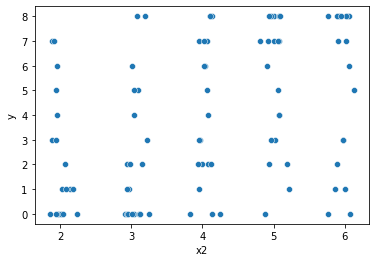

In [23]:
sns.scatterplot(x='x2', y='y', data=data)
plt.show()

### ロジスティック回帰とロジットリンク関数

GLMは、確率分布・リンク関数・線形予測子を指定し、足し算の数式であらわされるモデル（線形モデル）。
ロジスティック回帰は、二項分布(確率分布)、ロジットリンク関数(リンク関数)を用いる。

$$
q_i = logistic (z_i) = \frac{1} {1+\exp(-z_i)}
$$

ziは、線形予測子で、 $z_i = \beta_1 + \beta_2 x_i + ...$

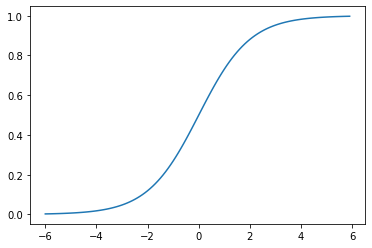

In [25]:
def sigmoid(zi):
    return 1 /(1+np.exp(-zi))

zi = np.arange(-6, 6, 0.1)
qi = sigmoid(zi)

plt.plot(zi, qi)
ｐｌｔ.show()

ロジット関数は、ロジスティック関数の逆関数である。

$$
logit(q_i)=\log \frac {q_i}{1-q_i}
$$

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.glm('y + I(N-y)~ x', data=data, family=sm.families.Binomial())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [28]:
result = model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
==============================================================
Model:              GLM               AIC:            649.6056
Link Function:      logit             BIC:            62.5296 
Dependent Variable: ['y', 'I(N - y)'] Log-Likelihood: -322.80 
Date:               2020-10-04 15:45  LL-Null:        -369.60 
No. Observations:   100               Deviance:       513.84  
Df Model:           1                 Pearson chi2:   428.    
Df Residuals:       98                Scale:          1.0000  
Method:             IRLS                                      
---------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
---------------------------------------------------------------
Intercept  -2.1487    0.2372  -9.0574  0.0000  -2.6137  -1.6838
x           0.5104    0.0556   9.1790  0.0000   0.4014   0.6194
==============================================================

"""

In [30]:
β1 = -2.1487
β2 = 0.5104

In [40]:
x = np.linspace(2, 6, 10)
y = sigmoid(x*β2 + β1)*8

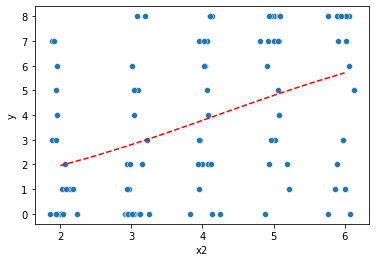

In [43]:
plt.plot(x, y, "r--")
sns.scatterplot(x='x2', y='y', data=data)

plt.show()

#　GLMではうまく扱えなそう

In [56]:
# x = 4の種子数の分布
data_4 = data[data['x']==4]
data_4 = data_4.groupby(by="y").count().reset_index()
data_4

,y,N,x,id,x2
0,0,3,3,3,3
1,1,1,1,1,1
2,2,4,4,4,4
3,3,2,2,2,2
4,4,1,1,1,1
5,5,1,1,1,1
6,6,2,2,2,2
7,7,3,3,3,3
8,8,3,3,3,3


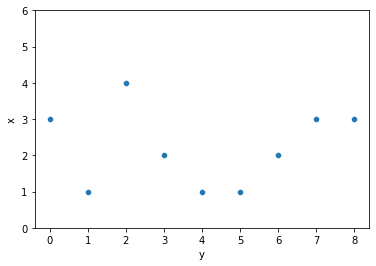

In [89]:
sns.scatterplot(x='y', y='x', data=data_4)
plt.ylim(0,6)
plt.show()

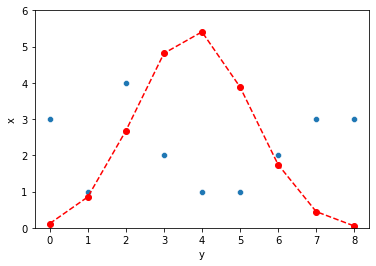

In [94]:
x = range(9)
#生存確率
p = sigmoid(β1+β2*4)
n = data_4.N.sum()
binomial = stats.binom.pmf(x, 8, p)*n
plt.plot(x, binomial, "ro--")

sns.scatterplot(x='y', y='x', data=data_4)
plt.ylim(0,6)
plt.show()

#　二項分布にしたがっているようには見えない

二項分布は、結果が2値であるベルヌーイの施行を独立にn回行った（上限がある）ときの確率変数をあらわす離散確率分布。

### 過分散と個体差

期待される分散よりも実際の分散が大きく、データのばらつきが大き過ぎること。全個体は均質であるという仮定のもと、一つの分布でデータを説明できると期待した結果、起こる。

In [102]:
# x=4における生存確率の平均
data_4.y.mean()/8

0.5

In [105]:
# x=4における生存数yiの分散
data_4.y.var()

7.5

In [106]:
#種子数yiが二項分布に従った場合の分散
data_4.y.var()*0.5*(1-0.5)

1.875

観察されていない個体差を考慮する必要がある。

### 一般化線形混合モデル
個体iの個体差をあらわすパラメータ$r_i$の追加

$$
logit(q_i) = \beta_1+\beta_2 x_i + r_i
$$

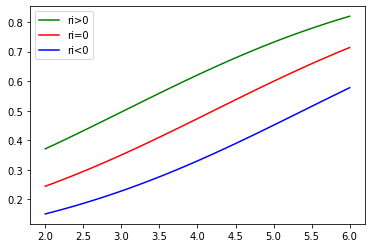

In [124]:
x = np.linspace(2, 6)
y1 = sigmoid(x*β2 + β1 + 0.6)
y2 = sigmoid(x*β2 + β1 + 0.0)
y3 = sigmoid(x*β2 + β1 - 0.6)

plt.plot(x, y1, "g-", label="ri>0")
plt.plot(x, y2, "r-", label="ri=0")
plt.plot(x, y3, "b-", label="ri<0")

plt.legend()
plt.show()

「観測されていない個体差などない」と仮定しているGLMは、観察されたデータで個体差なし（$r_i=0$）と設定している。

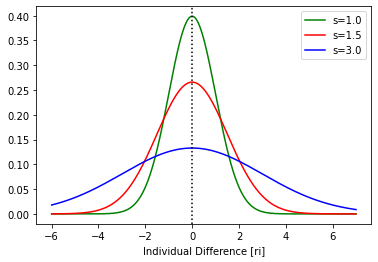

In [141]:
r = np.linspace(-6, 7, 1000)
plt.plot(pd.Series(stats.norm.pdf(r, loc=0, scale=1.), index=r), 'g', label='s=1.0')
plt.plot(pd.Series(stats.norm.pdf(r, loc=0, scale=1.5), index=r), 'r', label='s=1.5')
plt.plot(pd.Series(stats.norm.pdf(r, loc=0, scale=3.0), index=r), 'b', label='s=3.0')
plt.axvline(0, color='k', linestyle='dotted')
plt.xlabel("Individual Difference [ri]")
plt.legend()
plt.show()

個体差のばらつきsが大きいほど、過分散がひどくなる。